# Introduction

*   This notebook implements the "Expected Sarsa" algorithm for the "CartPole-v0" environment. For more information on the environment, please visit [here](https://gym.openai.com/envs/CartPole-v0/#barto83). Also, check the related paper [here](https://ieeexplore.ieee.org/document/6313077).



*   The algorithm and the related text is copied and pasted from Section 6.6 of the book "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto (second edition).



*   You can download the book [here](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf).

# Expected Sarsa

Consider the learning algorithm that is just like Q-learning except that instead of the maximum over next state–action pairs it uses the expected value, taking into account how likely each action is under the current policy. That is, consider the algorithm with the update rule

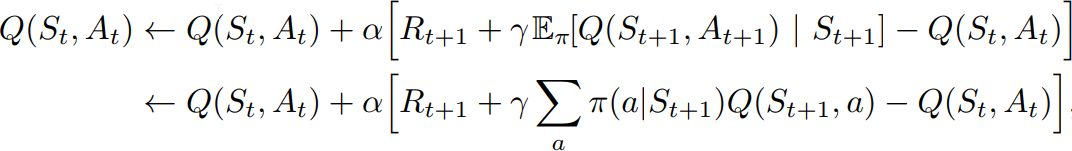

but that otherwise follows the schema of Q-learning. Given the next state, $S_{t+1}$, this algorithm moves *deterministically* in the same direction as Sarsa moves in *expectation*, and accordingly it is called *Expected Sarsa*.

Expected Sarsa is more complex computationally than Sarsa but, in return, it eliminates the variance due to the random selection of $A_{t+1}$. Given the same amount of experience we might expect it to perform slightly better than Sarsa, and indeed it generally does.

Here, Expected Sarsa is used on-policy, but in general it might use a policy different from the target policy $\pi$ to generate behavior, in which case it becomes an off-policy algorithm. For example, suppose $\pi$ is the greedy policy while behavior is more exploratory; then Expected Sarsa is exactly Q-learning. In this sense Expected Sarsa subsumes and generalizes Q-learning while reliably improving over Sarsa. Except for the small additional computational cost, Expected Sarsa may completely dominate both of the other more-well-known TD control algorithms.

# Python Implementation

**Import Packages**

In [ ]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt

**Expected Sarsa Agent**

In [ ]:
class Agent:

    def __init__(self, alpha, epsilon, gamma, state_space, action_space, num_actions):

        self.alpha = alpha  # step-size parameter
        self.epsilon = epsilon  # probability of taking a random action in an ε-greedy policy
        self.gamma = gamma  # discount-rate parameter (discount factor)
        self.state_space = state_space
        self.action_space = action_space
        self.num_actions = num_actions

        self.Q = {}
        for s in self.state_space:
            for a in range(self.num_actions):
                self.Q[s, a] = 0

    def policy(self, state):
        """
        Implement the ε-greedy action selection policy.
        """

        q_values = np.array([self.Q[state, a] for a in range(self.num_actions)])
        r = np.random.random()

        if r < self.epsilon:
            action = self.action_space.sample()  # random action - exploration
        else:
            action = np.argmax(q_values)  # greedy action - exploitation

        return action

    def update_values(self, state, action, reward, state_):
        """
        Update the action-value estimates.
        """

        # The probability of taking a random action, be it greedy or non-greedy, in an ε-greedy policy is equal to {ε}.
        # It means that each action, then again be it greedy or non-greedy, is taken with a probability of
        # {ε / num_actions}. The probability of taking a greedy action is equal to {1 - ε}. It means that each greedy
        # action is taken with a probability of {(1 - ε) / num_greedy_actions}. Therefore, each non-greedy action is
        # taken with a probability of {ε / num_actions} and each greedy action is taken with a probability of
        # {((1 - ε) / num_greedy_actions) + (ε / num_actions)}. To recap:
        # π(a non-greedy action | s) = ε / num_actions
        # π(a greedy action | s) = ((1 - ε) / num_greedy_actions) + (ε / num_actions)

        max_q_value = np.max(np.array([self.Q[state_, a] for a in range(self.num_actions)]))
        num_greedy_actions = 0

        for a in range(self.num_actions):
            if self.Q[state_, a] == max_q_value:
                num_greedy_actions += 1

        non_greedy_action_probability = self.epsilon / self.num_actions
        greedy_action_probability = ((1 - self.epsilon) / num_greedy_actions) + (self.epsilon / self.num_actions)
        expected_q = 0

        for a in range(self.num_actions):
            if self.Q[state_, a] == max_q_value:
                expected_q += greedy_action_probability * self.Q[state_, a]
            else:
                expected_q += non_greedy_action_probability * self.Q[state_, a]

        delta = reward + self.gamma * expected_q - self.Q[state, action]  # TD error
        self.Q[state, action] += self.alpha * delta

    def decrement_epsilon(self, episodes):
        """
        Decrease the value of ε after each episode.
        **Usage is optional.**
        """

        # This is to decrease the probability of taking a random action and ensure convergence with ε-greedy policies.
        # This is because as the action-value estimates change toward the optimal values, the need for exploration
        # decreases and more exploitation is needed.

        if self.epsilon > 0:
            self.epsilon -= 1 / episodes
        else:
            self.epsilon = 0

**Main Body**

In [ ]:
env = gym.make("CartPole-v0")
action_space = env.action_space  # Discrete(2) = [0, 1]
num_actions = 2
# print(env.observation_space.high)
# print(env.observation_space.low)

cart_position_bins = np.linspace(-2.4, 2.4, 19)  # 20 bins/buckets - [-2.4m 2.4m]
cart_velocity_bins = np.linspace(-4, 4, 19)  # 20 bins/buckets
pole_angle_bins = np.linspace(-12 * math.pi / 180, 12 * math.pi / 180, 19)  # 20 bins/buckets - [-12° 12°]
pole_angular_velocity_bins = np.linspace(-4, 4, 19)  # 20 bins/buckets
state_bins = [cart_position_bins, cart_velocity_bins, pole_angle_bins, pole_angular_velocity_bins]

state_space = []
for s1 in range(len(cart_position_bins) + 1):
    for s2 in range(len(cart_position_bins) + 1):
        for s3 in range(len(cart_position_bins) + 1):
            for s4 in range(len(cart_position_bins) + 1):
                state_space.append((s1, s2, s3, s4))


def discretize_obs_space(obs, bins):
    """
    Discretize the continuous observation space.
    """

    cart_position, cart_velocity, pole_angle, pole_angular_velocity = obs

    cart_position = int(np.digitize(cart_position, bins[0], right=False))
    cart_velocity = int(np.digitize(cart_velocity, bins[1], right=False))
    pole_angle = int(np.digitize(pole_angle, bins[2], right=False))
    pole_angular_velocity = int(np.digitize(pole_angular_velocity, bins[3], right=False))

    return cart_position, cart_velocity, pole_angle, pole_angular_velocity


alpha = 0.1  # step-size parameter
epsilon = 1.0  # probability of taking a random action in an ε-greedy policy
gamma = 0.99  # discount-rate parameter (discount factor)

agent = Agent(alpha, epsilon, gamma, state_space, action_space, num_actions)

episodes = 50000
total_rewards = []

for episode in range(1, episodes + 1):

    observation = env.reset()
    state = discretize_obs_space(observation, state_bins)
    done = False

    total_reward = 0
    steps = 0
    # actions = []

    while not done:

        # env.render()
        action = agent.policy(state)
        observation_, reward, done, info = env.step(action)
        state_ = discretize_obs_space(observation_, state_bins)
        agent.update_values(state, action, reward, state_)
        state = state_

        total_reward += reward
        steps += 1
        # actions.append(action)

    agent.decrement_epsilon(episodes)
    total_rewards.append(total_reward)

    if episode % 1000 == 0:
        print(f"============ Episode: {episode} ============")
        print(f"Total Reward: {total_reward}")
        print(f"Steps: {steps}")
        # print(f"Actions: {actions}")

# env.close()

**Plot**

In [ ]:
x_axis = [i for i in range(1, episodes + 1)]
y_axis = total_rewards

plt.figure(figsize=(12, 6), dpi=100)

plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.plot(x_axis, y_axis)
plt.grid()
plt.show()

**Simulation Results**

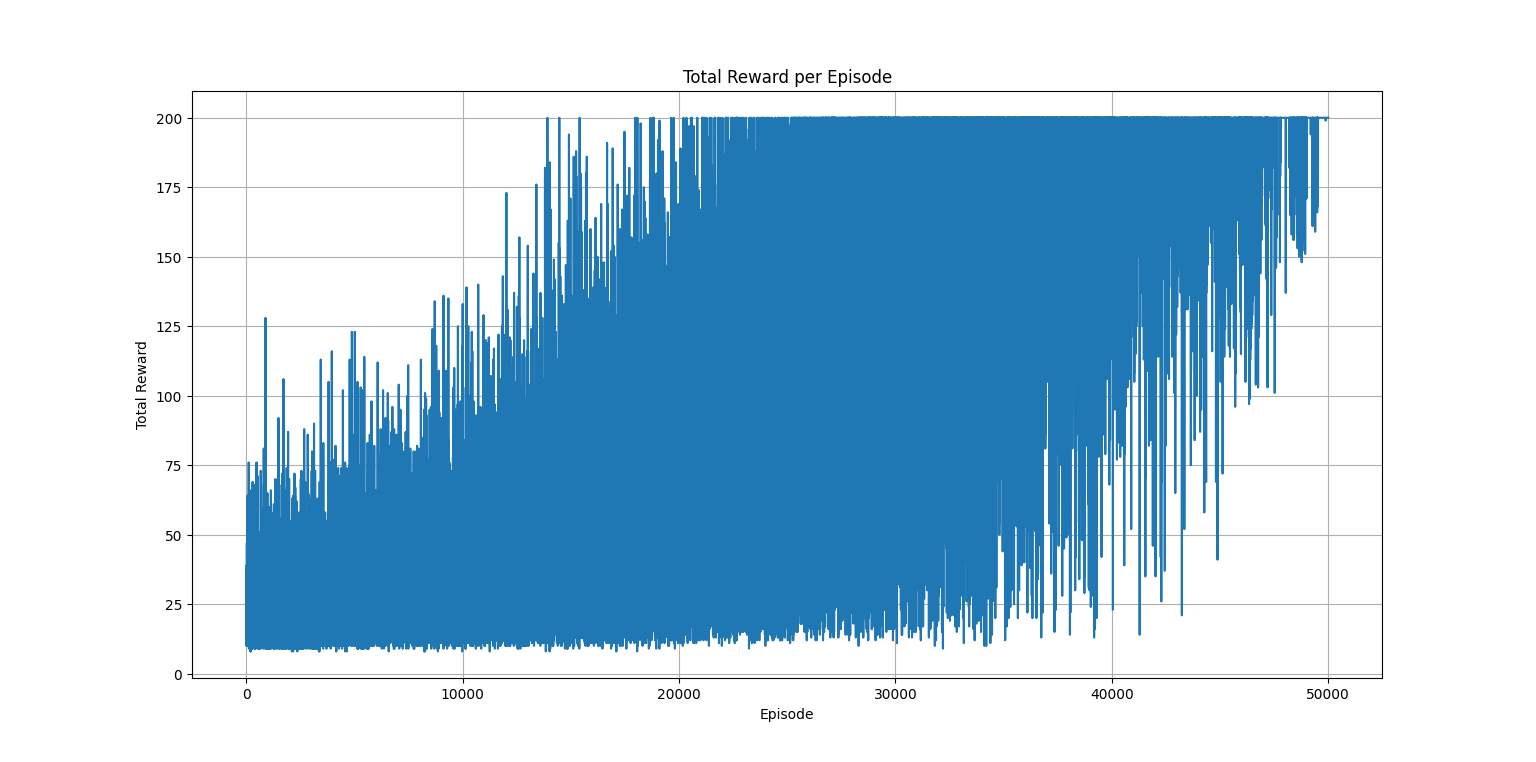